# EDA

In [50]:
import os
import re
import pandas as pd
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import welch
from tqdm import tqdm

In [45]:
AUDIO_DIR = "../input/train"
CSV_PATH = "../input/train.csv"
SR = 16000
TARGET_LEN = 16000

In [21]:
df = pd.read_csv(CSV_PATH)
df["Target"] = df["Target"].astype(str)

In [22]:
def reconstruct_filename(name):
    return name.replace("_E_", "_").replace("_I_", "_") + ".wav"

In [23]:
df["filename"] = df["ID"].apply(reconstruct_filename)

In [24]:
print("📊 Dataset shape:", df.shape)
print("🔁 Label counts:\n", df["Target"].value_counts())

📊 Dataset shape: (4000, 3)
🔁 Label counts:
 Target
I    2000
E    2000
Name: count, dtype: int64


In [25]:
durations = []
rms_levels = []

for fname in df["filename"]:
    path = os.path.join(AUDIO_DIR, fname)
    y, sr = librosa.load(path, sr=SR)
    durations.append(len(y) / sr)
    rms_levels.append(np.sqrt(np.mean(y**2)))

In [26]:
df["duration"] = durations
df["rms"] = rms_levels

print("\n🕒 Duration stats (seconds):")
print(df["duration"].describe())

print("\n🔊 RMS Loudness stats:")
print(df["rms"].describe())


🕒 Duration stats (seconds):
count    4000.0
mean        1.0
std         0.0
min         1.0
25%         1.0
50%         1.0
75%         1.0
max         1.0
Name: duration, dtype: float64

🔊 RMS Loudness stats:
count    4000.000000
mean        0.032345
std         0.038738
min         0.001750
25%         0.011243
50%         0.019295
75%         0.036172
max         0.434734
Name: rms, dtype: float64


=> All files: **EXACTLY 1.0 SEC LONG**

→ Skip dynamic padding/clipping logic in dataset.py...

- RMS spans 0.0017 to 0.4347, with a mean of approx 0.03

- 25% of samples are below 0.011

=> **Some recordings are very quiet**, possibly near-silent!!

-> We should: Normalize loudness, Add volume-based augmentations...

In [36]:
def load_wave(file_id):
    file_name = re.sub(r'_[EI]_', '_', file_id) + ".wav"
    file_path = os.path.join(AUDIO_DIR, file_name)
    y, sr = librosa.load(file_path, sr=16000)
    return y, sr

inhale_id = df[df.Target == "I"].iloc[0].ID
exhale_id = df[df.Target == "E"].iloc[0].ID

inhale_audio, sr = load_wave(inhale_id)
exhale_audio, _ = load_wave(exhale_id)

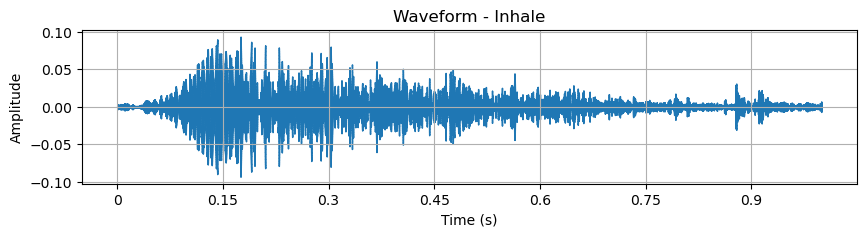

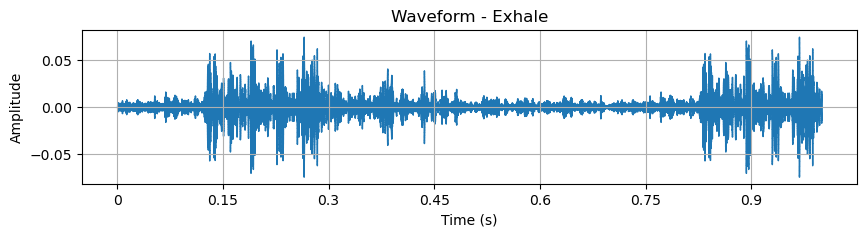

Duration (Inhale): 1.0 sec
Duration (Exhale): 1.0 sec


In [37]:
def plot_waveform(y, sr, title=""):
    plt.figure(figsize=(10, 2))
    librosa.display.waveshow(y, sr=sr)
    plt.title(title)
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.grid(True)
    plt.show()

plot_waveform(inhale_audio, sr, "Waveform - Inhale")
plot_waveform(exhale_audio, sr, "Waveform - Exhale")

print("Duration (Inhale):", len(inhale_audio)/sr, "sec")
print("Duration (Exhale):", len(exhale_audio)/sr, "sec")

In [40]:
def compute_average_abs_waveform(df, target_label, target_len=16000):
    abs_signals = []

    for _, row in df[df["Target"] == target_label].iterrows():
        file_id = row["ID"]
        file_name = re.sub(r'_[EI]_', '_', file_id) + ".wav"
        file_path = os.path.join(AUDIO_DIR, file_name)
        y, _ = librosa.load(file_path, sr=16000)

        if len(y) > target_len:
            y = y[:target_len]
        else:
            y = np.pad(y, (0, target_len - len(y)))

        abs_signals.append(np.abs(y))

    avg_abs = np.mean(abs_signals, axis=0)
    std_abs = np.std(abs_signals, axis=0)
    return avg_abs, std_abs

def plot_avg_abs_waveform(avg, std, sr, title):
    t = np.linspace(0, len(avg)/sr, len(avg))
    plt.figure(figsize=(10, 3))
    plt.plot(t, avg, label="Mean |Amplitude|", color="navy")
    plt.fill_between(t, avg - std, avg + std, alpha=0.3, color="navy", label="±1 std")
    plt.title(title)
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude (abs)")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

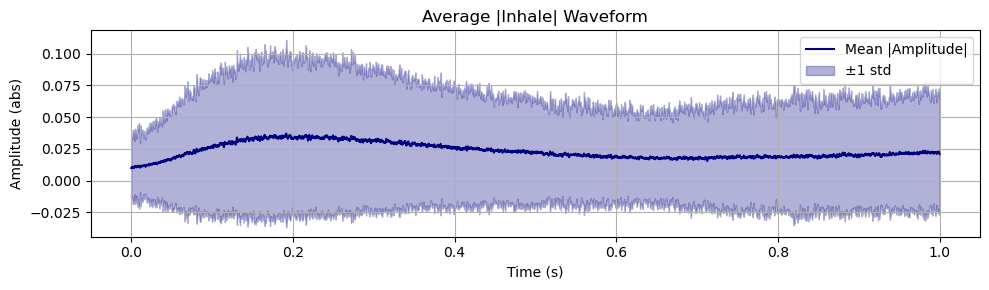

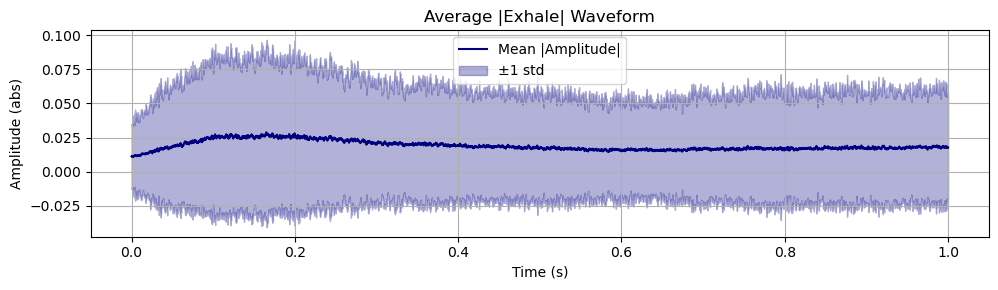

In [41]:
avg_inhale_abs, std_inhale_abs = compute_average_abs_waveform(df, "I")
avg_exhale_abs, std_exhale_abs = compute_average_abs_waveform(df, "E")

plot_avg_abs_waveform(avg_inhale_abs, std_inhale_abs, sr, "Average |Inhale| Waveform")
plot_avg_abs_waveform(avg_exhale_abs, std_exhale_abs, sr, "Average |Exhale| Waveform")

100%|██████████| 4000/4000 [00:04<00:00, 800.03it/s]


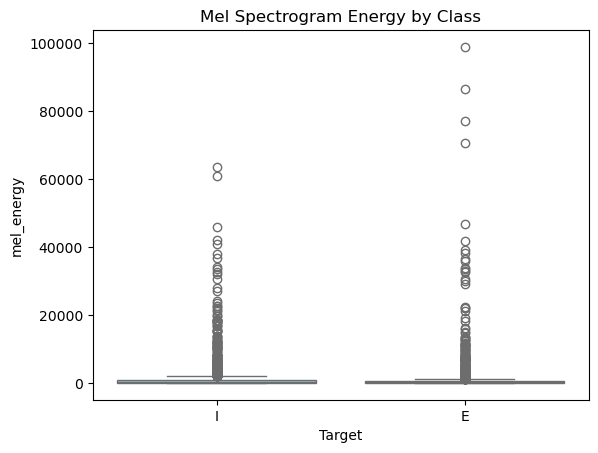

In [58]:
def compute_mel_energy(y, sr=SR):
    S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=64)
    return np.sum(S)

mel_energies = []
for _, row in tqdm(df.iterrows(), total=len(df)):
    file_name = re.sub(r'_[EI]_', '_', row["ID"]) + ".wav"
    y, _ = librosa.load(os.path.join(AUDIO_DIR, file_name), sr=SR)
    mel_energy = compute_mel_energy(y[:TARGET_LEN])
    mel_energies.append(mel_energy)

df["mel_energy"] = mel_energies

sns.boxplot(data=df, x="Target", y="mel_energy", hue="Target", palette=["skyblue", "salmon"])
plt.title("Mel Spectrogram Energy by Class")
plt.show()

In [65]:
mel_stats = df.groupby("Target")["mel_energy"].describe().round(3)
display(mel_stats)

,count,mean,std,min,25%,50%,75%,max
Target,,,,,,,,
E,2000.0,1205.207,5120.231,3.873,47.836,142.138,513.962,98959.148
I,2000.0,1456.563,4335.958,1.229,82.203,244.647,874.522,63665.457


Mel-Spectrogram Energy Interpretation:

- Inhale (I) samples have higher average Mel energy than Exhale (E).
- Distributions are highly skewed — note the large max values vs. medians.
- The median inhale is ~244, while median exhale is ~142, which aligns with your task’s audio nature (inhales often involve stronger airflow bursts).

100%|██████████| 4000/4000 [00:01<00:00, 2273.46it/s]


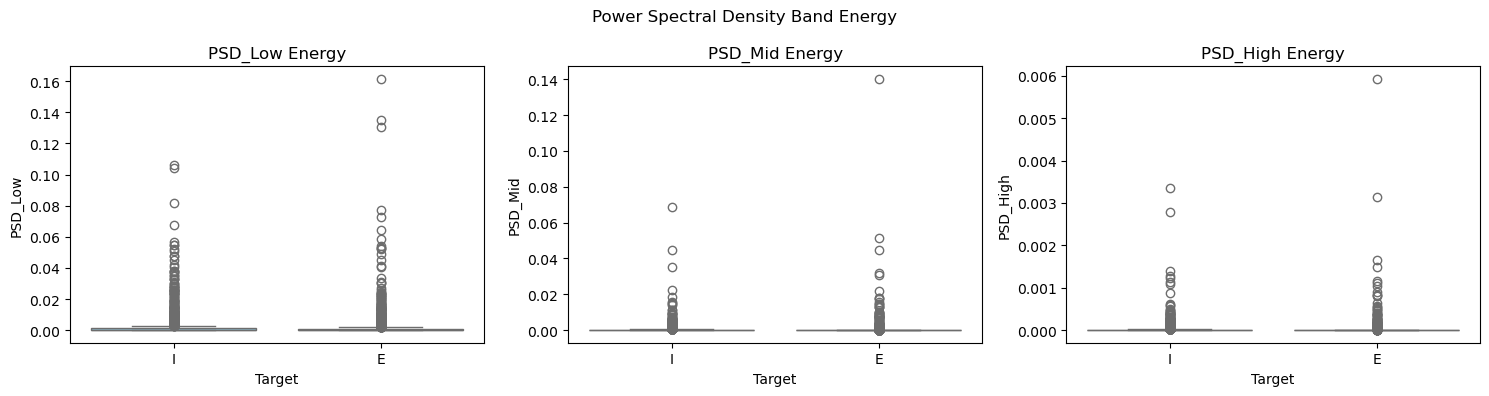

In [57]:
def compute_psd_band_energy(y, bands=[(0, 300), (300, 1000), (1000, 3000)]):
    freqs, psd = welch(y, SR, nperseg=1024)
    energies = [np.trapezoid(psd[(freqs >= fmin) & (freqs < fmax)], freqs[(freqs >= fmin) & (freqs < fmax)])
                for fmin, fmax in bands]
    return energies

psd_values = []
for _, row in tqdm(df.iterrows(), total=len(df)):
    file_name = re.sub(r'_[EI]_', '_', row["ID"]) + ".wav"
    y, _ = librosa.load(os.path.join(AUDIO_DIR, file_name), sr=SR)
    bands = compute_psd_band_energy(y[:TARGET_LEN])
    psd_values.append([row["Target"]] + bands)

psd_df = pd.DataFrame(psd_values, columns=["Target", "PSD_Low", "PSD_Mid", "PSD_High"])

fig, axes = plt.subplots(1, 3, figsize=(15, 4))
for i, band in enumerate(["PSD_Low", "PSD_Mid", "PSD_High"]):
    sns.boxplot(data=psd_df, x="Target", y=band, ax=axes[i], hue="Target", palette=["skyblue", "salmon"])
    axes[i].set_title(f"{band} Energy")

plt.suptitle("Power Spectral Density Band Energy")
plt.tight_layout()
plt.show()

In [63]:
psd_stats = psd_df.groupby("Target")[["PSD_Low", "PSD_Mid", "PSD_High"]].describe().round(4)
display(psd_stats)

PSD_Low                                                      PSD_Mid  \
         count    mean     std  min     25%     50%     75%     max   count   
Target                                                                        
E       2000.0  0.0018  0.0077  0.0  0.0001  0.0002  0.0008  0.1615  2000.0   
I       2000.0  0.0023  0.0069  0.0  0.0001  0.0004  0.0012  0.1061  2000.0   

                ...                 PSD_High                                   \
          mean  ...     75%     max    count mean     std  min  25%  50%  75%   
Target          ...                                                             
E       0.0005  ...  0.0001  0.1402   2000.0  0.0  0.0002  0.0  0.0  0.0  0.0   
I       0.0005  ...  0.0002  0.0687   2000.0  0.0  0.0001  0.0  0.0  0.0  0.0   

                
           max  
Target          
E       0.0059  
I       0.0033  

[2 rows x 24 columns]

PSD Band Energy

- Low: Inhale has slightly more low-frequency power, but both are very low-magnitude and tightly clustered.
- Mid: very sparse, often zero. May not be useful without log-scaling or aggregation.
- High: Both classes have negligible high-frequency energy, as expected in breath sounds